<a href="https://colab.research.google.com/github/workwithjahan/MISA_Atlas-Segmentation/blob/main/misa2_k_means_init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from numpy.linalg import inv, det, norm
from math import sqrt, pi
from functools import partial
from scipy.spatial.distance import dice
import time
import operator
import math

In [ ]:
#Showing the 2d slices
def show_slice(img, slice_no):
   
    plt.figure()
    plt.imshow(img[:,:,slice_no].T, cmap='gray')

def gmm(x, mean, cov): 
    
    return np.exp(-0.5*(x - mean) @ inv(cov) @ np.transpose(x - mean)) / (2 * pi * sqrt(det(cov)))


In [ ]:
def dice_similarity(Seg_img, GT_img,state):
    """   
    Inputs:
        Seg_img (numpy.ndarray): Segmented Image.
        GT_img (numpy.ndarray): Ground Truth Image.
        State: "nifti" if the images are nifti file
               "arr"   if the images are an ndarray
    output:
        Dice Similarity Coefficient: dice_CSF, dice_GM, dice_WM."""
    import numpy as np
    if (state=="nifti"):
       segmented_data = Seg_img.get_data().copy()
       groundtruth_data = GT_img.get_data().copy()
    elif (state=="arr"):
       segmented_data = Seg_img.copy()
       groundtruth_data = GT_img.copy()
    
    #Calculte DICE
    def dice_coefficient(SI,GT):
        #   2 * TP / (FN + (2 * TP) + FP)
        intersection = np.logical_and(SI, GT)
        return 2. * intersection.sum() / (SI.sum() + GT.sum())

      #Dice  for CSF
    Seg_CSF = (segmented_data == 1) * 1
    GT_CSF = (groundtruth_data == 1) * 1
    dice_CSF = dice_coefficient(Seg_CSF, GT_CSF)
    #Dice  for GM
    Seg_GM = (segmented_data == 2) * 1
    GT_GM = (groundtruth_data == 2) * 1
    dice_GM = dice_coefficient(Seg_GM, GT_GM)
    #Dice  for WM
    Seg_WM = (segmented_data == 3) * 1
    GT_WM = (groundtruth_data == 3) * 1
    dice_WM = dice_coefficient(Seg_WM, GT_WM)
    
    return dice_CSF, dice_GM, dice_WM
    


In [ ]:
def Dice_and_Visualization_of_one_slice(Seg_img, GT_img,state,number_of_slice):
    import numpy as np
    if (state=="nifti"):
       segmented_data = Seg_img.get_data().copy()
       groundtruth_data = GT_img.get_data().copy()
    elif (state=="arr"):
       segmented_data = Seg_img.copy()
       groundtruth_data = GT_img.copy()
    
    #Calculte DICE
    def dice_coefficient(SI,GT):
        #   2 * TP / (FN + (2 * TP) + FP)
        intersection = np.logical_and(SI, GT)
        return 2. * intersection.sum() / (SI.sum() + GT.sum())

    #Dice  for CSF
    Seg_CSF = (segmented_data == 1) * 1
    GT_CSF = (groundtruth_data == 1) * 1
    dice_CSF = dice_coefficient(Seg_CSF, GT_CSF)
    #Dice  for GM
    Seg_GM = (segmented_data == 2) * 1
    GT_GM = (groundtruth_data == 2) * 1
    dice_GM = dice_coefficient(Seg_GM, GT_GM)
    #Dice  for WM
    Seg_WM = (segmented_data == 3) * 1
    GT_WM = (groundtruth_data == 3) * 1
    dice_WM = dice_coefficient(Seg_WM, GT_WM)
    
    #print("CSF DICE = {}".format(dice_CSF), "GM DICE = {}".format(dice_GM), "WM DICE = {}".format(dice_WM))
    

    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(12,8))
    ax1.set_title("Seg.of CSF #{}".format(number_of_slice))
    img1 = ax1.imshow(Seg_CSF[:,:,number_of_slice], cmap = "gray")
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)

    ax2.set_title("Seg.of GM #{}".format(number_of_slice))
    img2 = ax2.imshow(Seg_GM[:,:,number_of_slice], cmap = "gray")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    ax3.set_title("Seg.of WM #{}".format(number_of_slice))
    img3 = ax3.imshow(Seg_WM[:,:,30], cmap = "gray")
    ax3.axes.get_xaxis().set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)

    ax4.set_title("GT.of CSF #{}".format(number_of_slice))
    img4 = ax4.imshow(GT_CSF[:,:,number_of_slice], cmap = "gray")
    ax4.axes.get_xaxis().set_visible(False)
    ax4.axes.get_yaxis().set_visible(False)

    ax5.set_title("GT.of GM #{}".format(number_of_slice))
    img5 = ax5.imshow(GT_GM[:,:,number_of_slice], cmap = "gray")
    ax5.axes.get_xaxis().set_visible(False)
    ax5.axes.get_yaxis().set_visible(False)
    
    ax6.set_title("GT.of WM #{}".format(number_of_slice))
    img6 = ax6.imshow(GT_WM[:,:,number_of_slice], cmap = "gray")
    ax6.axes.get_xaxis().set_visible(False)
    ax6.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


"\nfig_rows = 6\nfig_cols = 4\nn_subplots = fig_rows * fig_cols\nn_slice = T1_img.shape[0]\nstep_size = n_slice // n_subplots\nplot_range = n_subplots * step_size\nstart_stop = int((n_slice - plot_range) / 1)\n\nfig, axs = plt.subplots(fig_rows, fig_cols, figsize=[15,15])\n\nfor idx, img in enumerate(range(start_stop, plot_range, step_size)):\n    axs.flat[idx].imshow(T1_img[img, :, :], cmap='gray')\n    axs.flat[idx].axis('off')\n        \nplt.tight_layout()\nplt.show()\n"

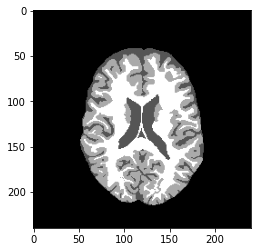

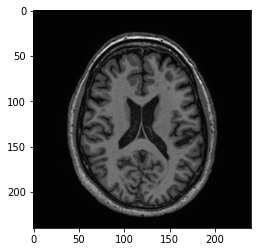

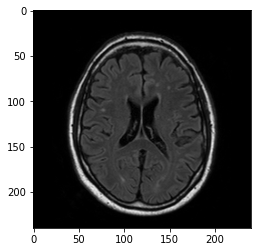

In [ ]:
# Load image Data
# =============================================================================

# let's load our google drive
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
# Define the root data directory
brain_data_path  = "/content/drive/MyDrive/misalab/P2_data/5";
#Load data
#Load T1_image
T1_data = os.path.join(brain_data_path, 'T1.nii')
T1_data = nib.load(T1_data)
T1_img=T1_data.get_fdata()
#Load T2_Flair_image
Flair_data = os.path.join(brain_data_path, 'T2_FLAIR.nii')
Flair_data = nib.load(Flair_data)
Flair_img=Flair_data.get_fdata() ##Data arrat
#Load Label Image
Label_data = os.path.join(brain_data_path, 'LabelsForTesting.nii')
Label_data = nib.load(Label_data)
Label_img=Label_data.get_fdata()

###Ploting image    
show_slice(Label_img,24)
show_slice(T1_img, 24)
show_slice(Flair_img,24)

#viewing all the slices
'''
fig_rows = 6
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = T1_img.shape[0]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 1)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[15,15])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(T1_img[img, :, :], cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()
'''

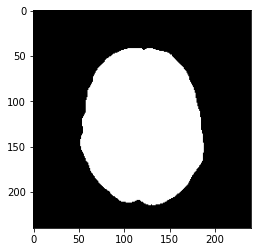

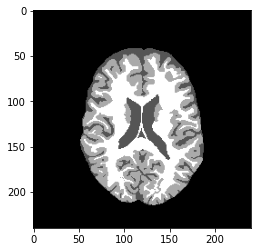

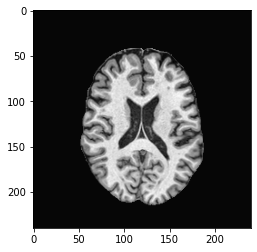

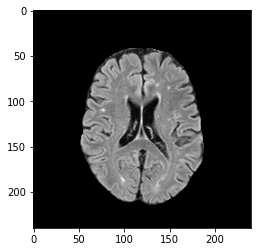

In [ ]:
"""Making Binary Mask for the Lable Image, for ROI can extraction  
 """
#making a copy of Label Data
Copy_Label=Label_img.copy()
#If the picel value is greater then 0 make it 1
Copy_Label[Copy_Label>0]=1
## Multiplying with image
T1_masked=np.multiply(T1_img, Copy_Label)
Flair_masked=np.multiply(Flair_img, Copy_Label)
#Saving the masked RIO images
T1_roi_data=nib.Nifti1Image(T1_masked, T1_data.affine, T1_data.header)
T1_roi=T1_roi_data.get_fdata()

Flair_roi_data=nib.Nifti1Image(Flair_masked, Flair_data.affine, Flair_data.header)
Flair_roi=Flair_roi_data.get_fdata()
#Showing the slices



show_slice(Copy_Label, 24)
show_slice(Label_img, 24)
show_slice(T1_roi, 24)
show_slice(Flair_roi, 24)



In [ ]:
#vectorization
# Making the Feature Vector
T1_flatten=T1_roi.copy().flatten()
Flair_flatten=Flair_roi.copy().flatten()

Feature_data=np.vstack((T1_flatten, Flair_flatten)) #bimodal
Feature_data=np.transpose(Feature_data)

In [ ]:
T1_flatten

array([0., 0., 0., ..., 0., 0., 0.])

allows us to loop over something and have an automatic counter
"""

In [ ]:
##### 
Feature_data_nonzero_row_indicies = [i for i, x in enumerate(Feature_data) if x.any()]
Feature_data_nonzero = Feature_data[Feature_data_nonzero_row_indicies]


In [ ]:
# Initialization
# =============================================================================
"""
Kmeans Clustering is used from sklearn.cluster.KMeans
Input: n_clusters= Number of cluster
       K-means++: initial cluster centers for k-mean clustering in a smart way to speed up convergence
       Random State :Determines random number generation for centroid initialization. 
                     Use an int to make the randomness deterministic
Output:
      Kmeans_predict= level index
      Centroid= Mean
""" 
kmeans=KMeans(n_clusters=3,  init='k-means++',random_state=0,).fit(Feature_data_nonzero)
Kmeans_predict=kmeans.predict(Feature_data_nonzero)
centroids = kmeans.cluster_centers_



"""
Here the kmeasns is changing the cluster index every time it runs
so we make the Keam cluster indexes to a robust format.
"""


##Finding the minimum and maximum Indexes
#Taking the T1 weighted mean
T1_colum_centroid=centroids[:,0]
##min and max
min_index, min_value = min(enumerate(T1_colum_centroid), key=operator.itemgetter(1))
max_index, max_value = max(enumerate(T1_colum_centroid), key=operator.itemgetter(1))


############# Making the Clustering Robust ##########
#Taking the Shape of the centroid
Shape_Centroid=centroids.shape 
Kmeans_predict_new=np.zeros(len(Kmeans_predict))
centroid_new=np.zeros(Shape_Centroid)


##Centrioid arranging
centroid_new[0]=centroids[min_index]
centroid_new[2]=centroids[max_index]
#Rearranging the Centrioid
if (min_index+max_index==1):
   centroid_new[1]=centroids[2]
elif (min_index+max_index==2):
   centroid_new[1]=centroids[1]
elif (min_index+max_index==3):
   centroid_new[1]=centroids[0]


##Making then new labels
for i in range(0,len(Kmeans_predict)):
    if (Kmeans_predict[i]==min_index):
        Kmeans_predict_new[i]=0
    elif(Kmeans_predict[i]==max_index):
        Kmeans_predict_new[i]=2
    else:
        Kmeans_predict_new[i]=1

Kmeans_predict_new=Kmeans_predict_new+1 


class_CSF = Feature_data_nonzero[np.argwhere(Kmeans_predict_new ==1)[:,0],:]
class_GM = Feature_data_nonzero[np.argwhere(Kmeans_predict_new== 2)[:,0],:]
class_WM = Feature_data_nonzero[np.argwhere(Kmeans_predict_new== 3)[:,0],:]



###Computing the mean and coveriences
mean_CSF = np.mean(class_CSF, axis = 0)
mean_GM = np.mean(class_GM, axis = 0)
mean_WM = np.mean(class_WM , axis = 0)
cov_CSF = np.cov(class_CSF, rowvar = False)
cov_GM = np.cov(class_GM, rowvar = False)
cov_WM = np.cov(class_WM , rowvar = False)


# Prior_Probabibilities
pp_of_CSF = class_CSF.shape[0] / Feature_data_nonzero.shape[0] # alpha
pp_of_GM = class_GM.shape[0] /Feature_data_nonzero.shape[0]
pp_of_WM = class_WM.shape[0] / Feature_data_nonzero.shape[0]


##Ploting the cluster distributin    
#plt.figure()
#plt.scatter(Feature_data_nonzero[:, 0], Feature_data_nonzero[:, 1], c=Kmeans_predict_new, s=25)
#plt.scatter(centroid_new[:, 0], centroid_new[:, 1], marker='x', s=200, linewidths=3, color='w', zorder=10)
#plt.show()
'''
fig = plt.figure()
ax = fig.gca(projection='3d')
# Plot scatterplot data (20 2D points per colour) on the x and z axes.
colors = ('r', 'g', 'b', 'k')
ax.scatter(Feature_data_nonzero[:, 0], Feature_data_nonzero[:, 1], c=Kmeans_predict_new, label='points in (x,z)')
ax.scatter(centroid_new[:, 0], centroid_new[:, 1], marker='x', s=200, linewidths=3, color='w', zorder=10)
# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=100., azim=-10)
plt.show()
'''


In [ ]:
'''
##Ploting the cluster distributin    
plt.figure()
plt.scatter(Feature_data_nonzero[:, 0], Feature_data_nonzero[:, 1], c=Kmeans_predict_new, s=25)
plt.scatter(centroid_new[:, 0], centroid_new[:, 1], marker='x', s=200, linewidths=3, color='w', zorder=10)
plt.show()
'''

In [ ]:
# EM algorithm

MAX_STEPS = 300
min_change = 0.001
n_steps = 0
cls_dist = np.array((pp_of_CSF, pp_of_GM , pp_of_WM))

while True:

   gmm_of_CSF= np.apply_along_axis(partial(gmm, mean=mean_CSF, cov=cov_CSF), 1, Feature_data_nonzero)
   gmm_of_GM= np.apply_along_axis(partial(gmm, mean=mean_GM, cov=cov_GM), 1, Feature_data_nonzero)
   gmm_of_WM= np.apply_along_axis(partial(gmm, mean=mean_WM, cov=cov_WM), 1, Feature_data_nonzero)

   Denominator_of_Softsegmentation= (pp_of_CSF*gmm_of_CSF)+(pp_of_GM*gmm_of_GM)+(pp_of_WM*gmm_of_WM)

   weights_CSF=(pp_of_CSF*gmm_of_CSF)/Denominator_of_Softsegmentation
   weights_GM=(pp_of_GM*gmm_of_GM)/Denominator_of_Softsegmentation
   weights_WM=(pp_of_WM*gmm_of_WM)/Denominator_of_Softsegmentation

   weights=np.vstack((weights_CSF,weights_GM,weights_WM))
   weights=np.transpose(weights)

     ####
   log_b=sum((np.log(sum(weights))))

   #maximization steps
   
   Prediction=np.argmax(weights,axis=1)
   Prediction=Prediction+1
 

 #calculating new alpha
   _,counts = np.unique(Prediction, return_counts=True)
   pp_of_CSF = counts[0] / Feature_data_nonzero.shape[0]
   pp_of_GM = counts[1] / Feature_data_nonzero.shape[0]
   pp_of_WM = counts[2] / Feature_data_nonzero.shape[0]

   cls_dist_new = np.array((pp_of_CSF, pp_of_GM , pp_of_WM))

####### calculate new mean and cOVARIENCE
   mean_CSF= (1/counts[0]) * (weights[:, 0] @ Feature_data_nonzero)
   mean_GM= (1/counts[1]) * (weights[:, 1] @ Feature_data_nonzero)
   mean_WM= (1/counts[2]) * (weights[:, 2] @ Feature_data_nonzero)
   cov_CSF = (1/counts[0]) * (weights[:, 0] * np.transpose(Feature_data_nonzero - mean_CSF)) @ (Feature_data_nonzero - mean_CSF)
   cov_GM= (1/counts[1]) * (weights[:, 1] * np.transpose(Feature_data_nonzero - mean_GM)) @ (Feature_data_nonzero - mean_GM)
   cov_WM= (1/counts[2]) * (weights[:, 2] * np.transpose(Feature_data_nonzero - mean_WM)) @ (Feature_data_nonzero - mean_WM)

# =============================================================================
   gmm_of_CSF= np.apply_along_axis(partial(gmm, mean=mean_CSF, cov=cov_CSF), 1, Feature_data_nonzero)
   gmm_of_GM= np.apply_along_axis(partial(gmm, mean=mean_GM, cov=cov_GM), 1, Feature_data_nonzero)
   gmm_of_WM= np.apply_along_axis(partial(gmm, mean=mean_WM, cov=cov_WM), 1, Feature_data_nonzero)

   Denominator_of_Softsegmentation= (pp_of_CSF*gmm_of_CSF)+(pp_of_GM*gmm_of_GM)+(pp_of_WM*gmm_of_WM)

   weights_CSF=(pp_of_CSF*gmm_of_CSF)/Denominator_of_Softsegmentation
   weights_GM=(pp_of_GM*gmm_of_GM)/Denominator_of_Softsegmentation
   weights_WM=(pp_of_WM*gmm_of_WM)/Denominator_of_Softsegmentation

   weights=np.vstack((weights_CSF,weights_GM,weights_WM))
   weights=np.transpose(weights)
   
   ####
   log_n=sum((np.log(sum(weights))))
   
   
 
   dist_change = norm(cls_dist_new - cls_dist)
   log_changes=  norm(log_n-log_b)
   print("-------------------------------------")
   print("Step %d" % n_steps)
   print("Distribution change %f" % dist_change)
   print("log change %f" %  log_changes)
   n_steps += 1
   
    # check whether we reached desired precision or max number of steps
   if (n_steps >= MAX_STEPS) or (log_changes <= min_change):
       print("Maximization Done")
       break
   else:
        cls_dist = cls_dist_new



   
    

-------------------------------------
Step 0
Distribution change 0.019252
log change 0.010457
-------------------------------------
Step 1
Distribution change 0.012762
log change 0.009305
-------------------------------------
Step 2
Distribution change 0.011222
log change 0.007625
-------------------------------------
Step 3
Distribution change 0.009866
log change 0.006106
-------------------------------------
Step 4
Distribution change 0.008482
log change 0.004508
-------------------------------------
Step 5
Distribution change 0.006762
log change 0.003321
-------------------------------------
Step 6
Distribution change 0.005236
log change 0.002431
-------------------------------------
Step 7
Distribution change 0.004052
log change 0.001994
-------------------------------------
Step 8
Distribution change 0.002653
log change 0.001339
-------------------------------------
Step 9
Distribution change 0.001096
log change 0.001042
-------------------------------------
Step 10
Distribution c

In [ ]:
Prediction

array([1, 1, 1, ..., 1, 1, 1])

CSF DICE = 0.8839997168816751 GM DICE = 0.8430644876257213 WM DICE = 0.8818876944003466


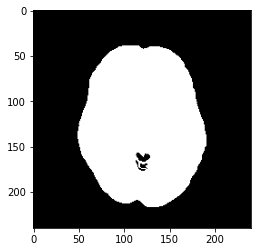

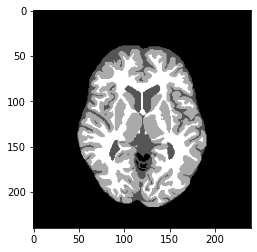

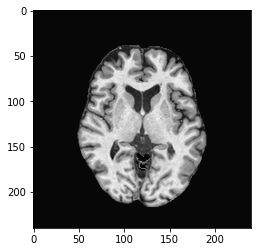

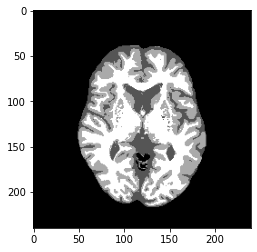

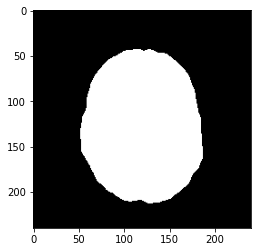

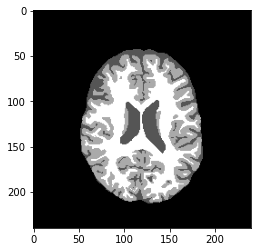

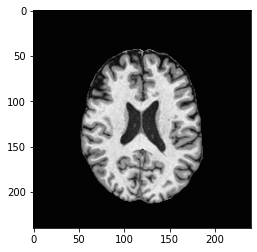

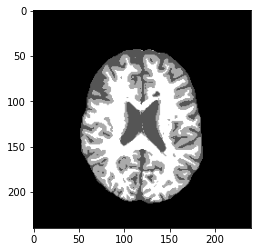

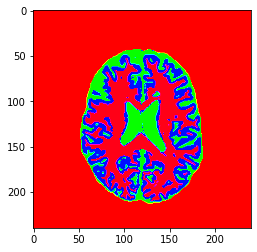

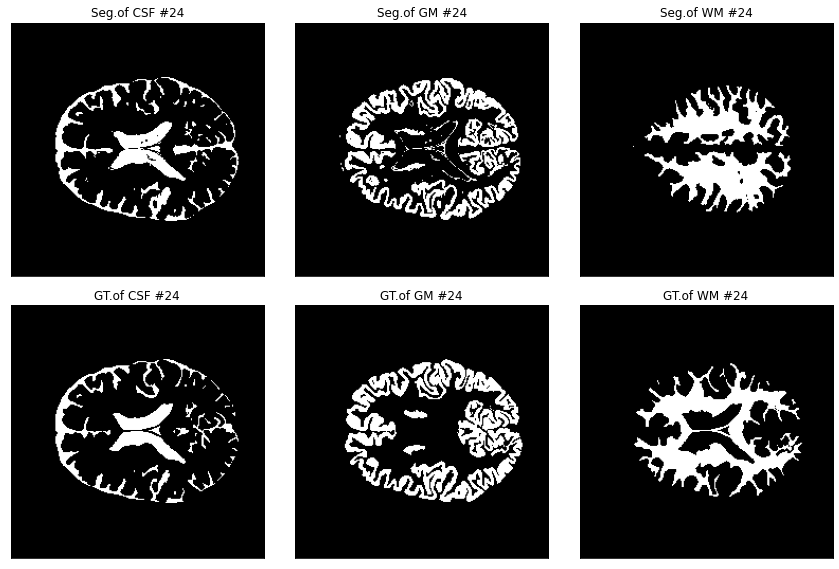

In [ ]:
#Recontruction of the image

shape_original_image=T1_img.shape

shape_orgibal_image_flatten=Flair_flatten.shape
segmented_image=np.zeros(shape_orgibal_image_flatten)
segmented_image[Feature_data_nonzero_row_indicies]=Prediction
Seg=np.reshape(segmented_image,shape_original_image)

#viewing few slices 
show_slice(Copy_Label, 20)
show_slice(Label_img, 20)
show_slice(T1_roi, 20)
show_slice(Seg, 20)

show_slice(Copy_Label, 25)
show_slice(Label_img, 25)
show_slice(T1_roi, 25)
show_slice(Seg, 25)


####Dice Calculation 
dice_CSF, dice_GM, dice_WM = dice_similarity(Seg,Label_img,"arr")
print("CSF DICE = {}".format(dice_CSF), "GM DICE = {}".format(dice_GM), "WM DICE = {}".format(dice_WM))
##Color Map
plt.figure()
plt.imshow(Seg[:,:,25].T, cmap='hsv')
###Visualization    
Dice_and_Visualization_of_one_slice(Seg,Label_img,"arr",24)